In [1]:
import sys

sys.path.append('/home/azhuravl/work/MonoDyGauBench_code')

from src.data import NerfiesDataModule

all_dataset = NerfiesDataModule(
    datadir='/home/azhuravl/nobackup/iphone/paper-windmill',
    eval=True,
    ratio=1.0,
    white_background=True,
    num_pts_ratio = 0.,
    num_pts =0,
    load_flow=False
)
all_dataset.setup('test')


277it [00:00, 27301.02it/s]


In [2]:
def find_synchronized_sequence_from_ids(train_ids, test_ids, test_camera_id=1, sequence_length=49):
    """Find synchronized consecutive sequences using ID lists directly"""
    
    # Extract frame numbers from IDs (format: "camera_frame")
    train_frame_map = {}  # frame_num -> index in train_ids
    test_frame_map = {}   # frame_num -> index in test_ids
    
    # Process train IDs
    for idx, train_id in enumerate(train_ids):
        frame_num = int(train_id.split('_')[1])
        train_frame_map[frame_num] = idx
    
    # Process test IDs - filter by specified camera
    for idx, test_id in enumerate(test_ids):
        camera_id, frame_num = test_id.split('_')
        camera_id = int(camera_id)
        frame_num = int(frame_num)
        
        # Only include frames from the specified test camera
        if camera_id == test_camera_id:
            test_frame_map[frame_num] = idx
    
    print(f"Train camera frames: {len(train_frame_map)}")
    print(f"Test camera {test_camera_id} frames: {len(test_frame_map)}")
    
    # Find common frame numbers
    common_frames = set(train_frame_map.keys()) & set(test_frame_map.keys())
    common_frames = sorted(list(common_frames))
    
    print(f"Found {len(common_frames)} common frame numbers")
    if common_frames:
        print(f"Frame range: {min(common_frames)} to {max(common_frames)}")
    
    # Find consecutive sequences
    sequences = []
    
    for start_idx in range(len(common_frames) - sequence_length + 1):
        frame_sequence = common_frames[start_idx:start_idx + sequence_length]
        
        # Check if consecutive
        is_consecutive = all(frame_sequence[i+1] == frame_sequence[i] + 1 
                           for i in range(len(frame_sequence) - 1))
        
        if is_consecutive:
            # Get dataset indices for these frame numbers
            train_indices = [train_frame_map[frame_num] for frame_num in frame_sequence]
            test_indices = [test_frame_map[frame_num] for frame_num in frame_sequence]
            
            # Get the actual IDs
            train_ids_seq = [train_ids[idx] for idx in train_indices]
            test_ids_seq = [test_ids[idx] for idx in test_indices]
            
            sequences.append({
                'frame_numbers': frame_sequence,
                'train_dataset_indices': train_indices,
                'test_dataset_indices': test_indices,
                'train_ids': train_ids_seq,
                'test_ids': test_ids_seq,
                'test_camera_id': test_camera_id,
                'start_frame': frame_sequence[0],
                'end_frame': frame_sequence[-1],
                'length': len(frame_sequence)
            })
    
    return sequences


def load_synchronized_sequence(sequence, train_dataset, test_dataset):
    """Load actual data only when needed"""
    train_data = [train_dataset[idx] for idx in sequence['train_dataset_indices']]
    test_data = [test_dataset[idx] for idx in sequence['test_dataset_indices']]
    return train_data, test_data



# For test camera 1
train_ids = all_dataset.train_cam_infos.train_id
test_ids = all_dataset.train_cam_infos.val_id

print("=== Using Test Camera 1 ===")
sequences_cam1 = find_synchronized_sequence_from_ids(train_ids, test_ids, test_camera_id=1, sequence_length=49)

print("=== Using Test Camera 2 ===")
sequences_cam2 = find_synchronized_sequence_from_ids(train_ids, test_ids, test_camera_id=2, sequence_length=49)

# Show results for both cameras
for cam_id, sequences in [(1, sequences_cam1), (2, sequences_cam2)]:
    print(f"\nCamera {cam_id}: Found {len(sequences)} consecutive sequences of 49 synchronized frames")
    
    for i, seq in enumerate(sequences[:2]):  # Show first 2
        print(f"\n  Sequence {i+1} (Camera {cam_id}):")
        print(f"    Frame numbers: {seq['start_frame']} to {seq['end_frame']}")
        print(f"    Train IDs: {seq['train_ids'][:3]} ... {seq['train_ids'][-3:]}")
        print(f"    Test IDs: {seq['test_ids'][:3]} ... {seq['test_ids'][-3:]}")
    


=== Using Test Camera 1 ===
Train camera frames: 277
Test camera 1 frames: 219
Found 219 common frame numbers
Frame range: 0 to 276
=== Using Test Camera 2 ===
Train camera frames: 277
Test camera 2 frames: 200
Found 200 common frame numbers
Frame range: 77 to 276

Camera 1: Found 123 consecutive sequences of 49 synchronized frames

  Sequence 1 (Camera 1):
    Frame numbers: 0 to 48
    Train IDs: ['0_00000', '0_00001', '0_00002'] ... ['0_00046', '0_00047', '0_00048']
    Test IDs: ['1_00000', '1_00001', '1_00002'] ... ['1_00046', '1_00047', '1_00048']

  Sequence 2 (Camera 1):
    Frame numbers: 1 to 49
    Train IDs: ['0_00001', '0_00002', '0_00003'] ... ['0_00047', '0_00048', '0_00049']
    Test IDs: ['1_00001', '1_00002', '1_00003'] ... ['1_00047', '1_00048', '1_00049']

Camera 2: Found 152 consecutive sequences of 49 synchronized frames

  Sequence 1 (Camera 2):
    Frame numbers: 77 to 125
    Train IDs: ['0_00077', '0_00078', '0_00079'] ... ['0_00123', '0_00124', '0_00125']
   

In [3]:
# Only load when you actually need the data
if sequences:
    best_seq = sequences_cam1[0]
    print(f"Selected sequence: frames {best_seq['start_frame']} to {best_seq['end_frame']}")
    
    # Load only this sequence
    train_sequence, test_sequence = load_synchronized_sequence(best_seq, train_dataset, test_dataset)
    
    print(f"Loaded {len(train_sequence)} train frames and {len(test_sequence)} test frames")


Selected sequence: frames 0 to 48


NameError: name 'train_dataset' is not defined

In [15]:
# Initialize dataset
all_dataset = NerfiesDataModule(
    datadir='/home/azhuravl/nobackup/iphone/paper-windmill',
    eval=True,
    ratio=0.5,
    white_background=True,
    num_pts_ratio=0.,
    num_pts=0,
    load_flow=False
)
all_dataset.setup('test')


277it [00:00, 76531.34it/s]


In [67]:
import torch
import numpy as np
import json
import os
import cv2
import sys
import math
import matplotlib.pyplot as plt

# Add dataset path
sys.path.append('/home/azhuravl/work/MonoDyGauBench_code')
from src.data import NerfiesDataModule

class NerfiesDataExtractor:
    """Simplified class to extract and process Nerfies data for visualization"""
    
    def convert_camera_format_from_nerfies(self, camera_data):
        """Convert Nerfies camera format to standard format"""
        # Extract camera parameters
        world_view_transform = camera_data['world_view_transform']  # [4, 4]
        full_proj_transform = camera_data['full_proj_transform']    # [4, 4] 
        camera_center = camera_data['camera_center']               # [3]
        FoVx = camera_data['FoVx']
        FoVy = camera_data['FoVy']
        image_height = camera_data['image_height']
        image_width = camera_data['image_width']
        
        # Convert FoV to focal lengths
        fx = image_width / (2.0 * math.tan(FoVx / 2.0))
        fy = image_height / (2.0 * math.tan(FoVy / 2.0))
        
        # Create intrinsic matrix
        K = torch.zeros(3, 3, dtype=torch.float32)
        K[0, 0] = fx  # focal length x
        K[1, 1] = fy  # focal length y
        K[0, 2] = image_width / 2.0   # principal point x
        K[1, 2] = image_height / 2.0  # principal point y
        K[2, 2] = 1.0
        
        # Convert world_view_transform to camera-to-world
        # c2w = torch.inverse(world_view_transform.T)
        c2w = torch.inverse(world_view_transform)
        # c2w = world_view_transform.T
        
        scale = 100
        c2w[:3, 3] = c2w[:3, 3] * scale
        
        
        return c2w, K
    
    def resize_frames_and_update_intrinsics(self, frames, original_K, target_size=(576, 1024)):
        """Resize frames and update camera intrinsics accordingly"""
        # frames: [T, H, W, C] numpy array
        original_height, original_width = frames.shape[1:3]
        target_height, target_width = target_size
        
        print(f"==> resizing from {original_width}x{original_height} to {target_width}x{target_height}")
        
        # Calculate scale factors
        scale_x = target_width / original_width
        scale_y = target_height / original_height
        
        # Resize frames
        resized_frames = []
        for frame in frames:
            # Ensure frame is in [0, 1] range
            if frame.max() <= 1.0:
                frame_uint8 = (frame * 255).astype(np.uint8)
            else:
                frame_uint8 = frame.astype(np.uint8)
            
            resized_frame = cv2.resize(frame_uint8, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
            resized_frames.append(resized_frame.astype(np.float32) / 255.0)
        
        resized_frames = np.stack(resized_frames)
        
        # Update intrinsic matrix
        updated_K = original_K.copy()
        updated_K[0, 0] *= scale_x  # fx
        updated_K[1, 1] *= scale_y  # fy
        updated_K[0, 2] *= scale_x  # cx
        updated_K[1, 2] *= scale_y  # cy
        
        return resized_frames, updated_K
    
    def resize_depth_maps(self, depths, target_size=(576, 1024)):
        """Resize depth maps to target size"""
        target_height, target_width = target_size
        
        resized_depths = []
        for depth in depths:
            resized_depth = cv2.resize(depth, (target_width, target_height), interpolation=cv2.INTER_NEAREST)
            resized_depths.append(resized_depth)
        
        return np.stack(resized_depths)
    
    def prepare_nerfies_data(self, train_sequence, test_sequence, target_size=(576, 1024)):
        """Prepare data from Nerfies dataset"""
        print(f"==> preparing Nerfies data (train=source, test=target)")
        
        # Extract frames (convert RGBA to RGB)
        source_frames = []
        target_frames = []
        source_depths = []
        
        for i, (train_data, test_data) in enumerate(zip(train_sequence, test_sequence)):
            # Convert RGBA to RGB and from [C, H, W] to [H, W, C]
            train_rgba = train_data['original_image'].permute(1, 2, 0).cpu().numpy()  # [H, W, 4]
            test_rgba = test_data['original_image'].permute(1, 2, 0).cpu().numpy()   # [H, W, 4]
            
            # Take RGB channels only (first 3)
            train_rgb = train_rgba[:, :, :3]
            test_rgb = test_rgba[:, :, :3]
            
            source_frames.append(train_rgb)
            target_frames.append(test_rgb)
            
            # Extract depth
            depth = train_data['depth'].cpu().numpy().astype(np.float32)
            source_depths.append(depth)
        
        source_frames = np.stack(source_frames)  # [T, H, W, 3]
        target_frames = np.stack(target_frames)  # [T, H, W, 3]
        source_depths = np.stack(source_depths)  # [T, H, W]
        
        print(f"==> source frames shape: {source_frames.shape}")
        print(f"==> target frames shape: {target_frames.shape}")
        print(f"==> source depths shape: {source_depths.shape}")
        
        # Get camera parameters from first frame
        source_c2w, source_K = self.convert_camera_format_from_nerfies(train_sequence[0])
        target_c2w, target_K = self.convert_camera_format_from_nerfies(test_sequence[0])
        
        # Store original camera params
        original_data = {
            'source_c2w_original': source_c2w.numpy(),
            'target_c2w_original': target_c2w.numpy(),
            'source_K_original': source_K.numpy(),
            'target_K_original': target_K.numpy(),
            'original_image_size': source_frames.shape[1:3]  # [H, W]
        }
        
        # Resize frames and update intrinsics
        resized_source_frames, updated_source_K = self.resize_frames_and_update_intrinsics(
            source_frames, source_K.numpy(), target_size
        )
        
        resized_target_frames, updated_target_K = self.resize_frames_and_update_intrinsics(
            target_frames, target_K.numpy(), target_size
        )
        
        # Resize depth maps
        resized_depths = self.resize_depth_maps(source_depths, target_size)
        
        return {
            'frames': resized_source_frames,
            'target_frames': resized_target_frames,
            'depths': resized_depths,
            'source_intrs': updated_source_K,
            'source_c2w': source_c2w.numpy(),
            'target_intrs': updated_target_K,  
            'target_c2w': target_c2w.numpy(),
            'seq_name': f"train_{train_sequence[0]['image_name']}_to_test_{test_sequence[0]['image_name']}",
            'original': original_data,  # Store original data for comparison
            'target_size': target_size
        }

def find_synchronized_sequence_from_ids(train_ids, test_ids, test_camera_id=1, sequence_length=49):
    """Find synchronized consecutive sequences using ID lists directly"""
    
    # Extract frame numbers from IDs (format: "camera_frame")
    train_frame_map = {}  # frame_num -> index in train_ids
    test_frame_map = {}   # frame_num -> index in test_ids
    
    # Process train IDs
    for idx, train_id in enumerate(train_ids):
        frame_num = int(train_id.split('_')[1])
        train_frame_map[frame_num] = idx
    
    # Process test IDs - filter by specified camera
    for idx, test_id in enumerate(test_ids):
        camera_id, frame_num = test_id.split('_')
        camera_id = int(camera_id)
        frame_num = int(frame_num)
        
        # Only include frames from the specified test camera
        if camera_id == test_camera_id:
            test_frame_map[frame_num] = idx
    
    print(f"Train camera frames: {len(train_frame_map)}")
    print(f"Test camera {test_camera_id} frames: {len(test_frame_map)}")
    
    # Find common frame numbers
    common_frames = set(train_frame_map.keys()) & set(test_frame_map.keys())
    common_frames = sorted(list(common_frames))
    
    print(f"Found {len(common_frames)} common frame numbers")
    if common_frames:
        print(f"Frame range: {min(common_frames)} to {max(common_frames)}")
    
    # Find consecutive sequences
    sequences = []
    
    for start_idx in range(len(common_frames) - sequence_length + 1):
        frame_sequence = common_frames[start_idx:start_idx + sequence_length]
        
        # Check if consecutive
        is_consecutive = all(frame_sequence[i+1] == frame_sequence[i] + 1 
                           for i in range(len(frame_sequence) - 1))
        
        if is_consecutive:
            # Get dataset indices for these frame numbers
            train_indices = [train_frame_map[frame_num] for frame_num in frame_sequence]
            test_indices = [test_frame_map[frame_num] for frame_num in frame_sequence]
            
            # Get the actual IDs
            train_ids_seq = [train_ids[idx] for idx in train_indices]
            test_ids_seq = [test_ids[idx] for idx in test_indices]
            
            sequences.append({
                'frame_numbers': frame_sequence,
                'train_dataset_indices': train_indices,
                'test_dataset_indices': test_indices,
                'train_ids': train_ids_seq,
                'test_ids': test_ids_seq,
                'test_camera_id': test_camera_id,
                'start_frame': frame_sequence[0],
                'end_frame': frame_sequence[-1],
                'length': len(frame_sequence)
            })
    
    return sequences

def load_synchronized_sequence(sequence, train_dataset, test_dataset):
    """Load actual data only when needed"""
    train_data = [train_dataset[idx] for idx in sequence['train_dataset_indices']]
    test_data = [test_dataset[idx] for idx in sequence['test_dataset_indices']]
    return train_data, test_data



In [68]:
test_camera_id = 1  # Choose test camera
num_frames = 10    # Number of frames to visualize


# Find synchronized sequence
train_ids = all_dataset.train_cam_infos.train_id
test_ids = all_dataset.train_cam_infos.val_id

sequences = find_synchronized_sequence_from_ids(
    train_ids, test_ids, test_camera_id, 49)

# Load the sequence (note the order swap from your code)
best_seq = sequences[0]
train_sequence, test_sequence = load_synchronized_sequence(best_seq, all_dataset.train_cameras, all_dataset.test_cameras)

# Limit to num_frames for visualization
train_sequence = train_sequence[:num_frames]
test_sequence = test_sequence[:num_frames]

# Initialize extractor
extractor = NerfiesDataExtractor()

# Prepare data
target_size = (576, 1024)  # Height, Width - same as your code
prepared_data = extractor.prepare_nerfies_data(train_sequence, test_sequence, target_size)


Train camera frames: 277
Test camera 1 frames: 219
Found 219 common frame numbers
Frame range: 0 to 276
==> preparing Nerfies data (train=source, test=target)
==> source frames shape: (10, 480, 360, 3)
==> target frames shape: (10, 480, 360, 3)
==> source depths shape: (10, 480, 360)
==> resizing from 360x480 to 1024x576
==> resizing from 360x480 to 1024x576


In [69]:
import viser
import threading
import time

print("Creating animated viser visualization...")

# Cell 1: Create Viser Server (run once)
# Check if server already exists and stop it
try:
    if 'server' in globals() and server is not None:
        print("Stopping existing server...")
        server.stop()
        del server
except:
    pass

# Create new server
print("Creating new Viser server ...")
server = viser.ViserServer(port=8082)
print("Server started successfully!")


Creating animated viser visualization...
Stopping existing server...


(viser) Connection closed (0, 0 total)

(viser) Server stopped

Creating new Viser server ...


╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8082   │
│   Websocket │ ws://localhost:8082     │
│             ╵                         │
╰───────────────────────────────────────╯

Server started successfully!


In [70]:
# Cell: Show All Camera Poses (Simple)

def create_colored_point_cloud_from_depth(depth, rgb_frame, K, c2w, subsample=8):
    """Create colored 3D point cloud from depth map, RGB frame, and camera parameters"""
    H, W = depth.shape
    
    # Create pixel coordinates (subsample for performance)
    v, u = np.meshgrid(np.arange(0, H, subsample), np.arange(0, W, subsample), indexing='ij')
    u = u.flatten()
    v = v.flatten()
    
    # Get depth and RGB values at subsampled locations
    depth_vals = depth[::subsample, ::subsample].flatten()
    rgb_vals = rgb_frame[::subsample, ::subsample].reshape(-1, 3)
    
    # Filter out invalid depths
    valid = (depth_vals > 0) & (depth_vals < 100)
    u, v, depth_vals, rgb_vals = u[valid], v[valid], depth_vals[valid], rgb_vals[valid]
    
    # Convert RGB to [0,255] if needed
    if rgb_vals.max() <= 1.0:
        rgb_vals = (rgb_vals * 255).astype(np.uint8)
    
    # Back-project to 3D camera coordinates
    x_cam = (u - K[0, 2]) * depth_vals / K[0, 0]
    y_cam = (v - K[1, 2]) * depth_vals / K[1, 1]
    z_cam = depth_vals
    
    # Transform to world coordinates
    points_cam = np.stack([x_cam, y_cam, z_cam, np.ones_like(x_cam)])
    points_world = c2w @ points_cam
    
    return points_world[:3].T, rgb_vals

# Clear scene
server.scene.reset()

# Show limited number of cameras to avoid clutter
max_cameras = min(10, len(train_sequence), len(test_sequence))
print(f"Showing {max_cameras} cameras from each sequence")

# Add all source cameras (train sequence)
for i in range(max_cameras):
    source_c2w, source_K = extractor.convert_camera_format_from_nerfies(train_sequence[i])
    source_c2w = source_c2w.numpy()
    
    # Highlight first camera
    if i == 0:
        scale, color = 0.08, (255, 50, 50)  # Large, bright red
        print(f"First source camera: {source_c2w[:3, 3]}")
    else:
        scale, color = 0.03, (150, 100, 100)  # Small, dim red
    
    server.scene.add_camera_frustum(
        name=f"source_{i}",
        fov=50,
        aspect=1.0,
        scale=scale,
        wxyz=viser.transforms.SO3.from_matrix(source_c2w[:3, :3]).wxyz,
        position=source_c2w[:3, 3],
        color=color
    )

# Add all target cameras (test sequence) 
for i in range(max_cameras):
    target_c2w, target_K = extractor.convert_camera_format_from_nerfies(test_sequence[i])
    target_c2w = target_c2w.numpy()
    
    # Highlight first camera
    if i == 0:
        scale, color = 0.08, (50, 50, 255)  # Large, bright blue
        print(f"First target camera: {target_c2w[:3, 3]}")
    else:
        scale, color = 0.03, (100, 100, 150)  # Small, dim blue
    
    server.scene.add_camera_frustum(
        name=f"target_{i}",
        fov=50,
        aspect=1.0,
        scale=scale,
        wxyz=viser.transforms.SO3.from_matrix(target_c2w[:3, :3]).wxyz,
        position=target_c2w[:3, 3],
        color=color
    )

# Add point cloud from first source camera
depth = prepared_data['depths'][0]
depth = (1 / (depth + 1e-6))  # Convert disparity to depth
source_rgb = prepared_data['frames'][0]
source_K = prepared_data['source_intrs']
source_c2w = prepared_data['source_c2w']

print("Creating point cloud from first source camera...")
points_3d, colors = create_colored_point_cloud_from_depth(
    depth, source_rgb, source_K, source_c2w, subsample=10
)

server.scene.add_point_cloud(
    name="pointcloud",
    points=points_3d,
    colors=colors,
    point_size=0.008
)

# Add coordinate frame
server.scene.add_frame(
    name="/origin", 
    axes_length=0.1, 
    position=(0, 0, 0)
)

print(f"✓ Done! Generated {len(points_3d)} points")
print("Check http://localhost:8082")
print("🔴 Large red = first source, small red = other sources")
print("🔵 Large blue = first target, small blue = other targets")

Showing 10 cameras from each sequence
First source camera: [ 0. -0. -0.]
First target camera: [ 0. -0. -0.]
Creating point cloud from first source camera...
✓ Done! Generated 5971 points
Check http://localhost:8082
🔴 Large red = first source, small red = other sources
🔵 Large blue = first target, small blue = other targets


(viser) Connection opened (0, 1 total), 69 persistent messages

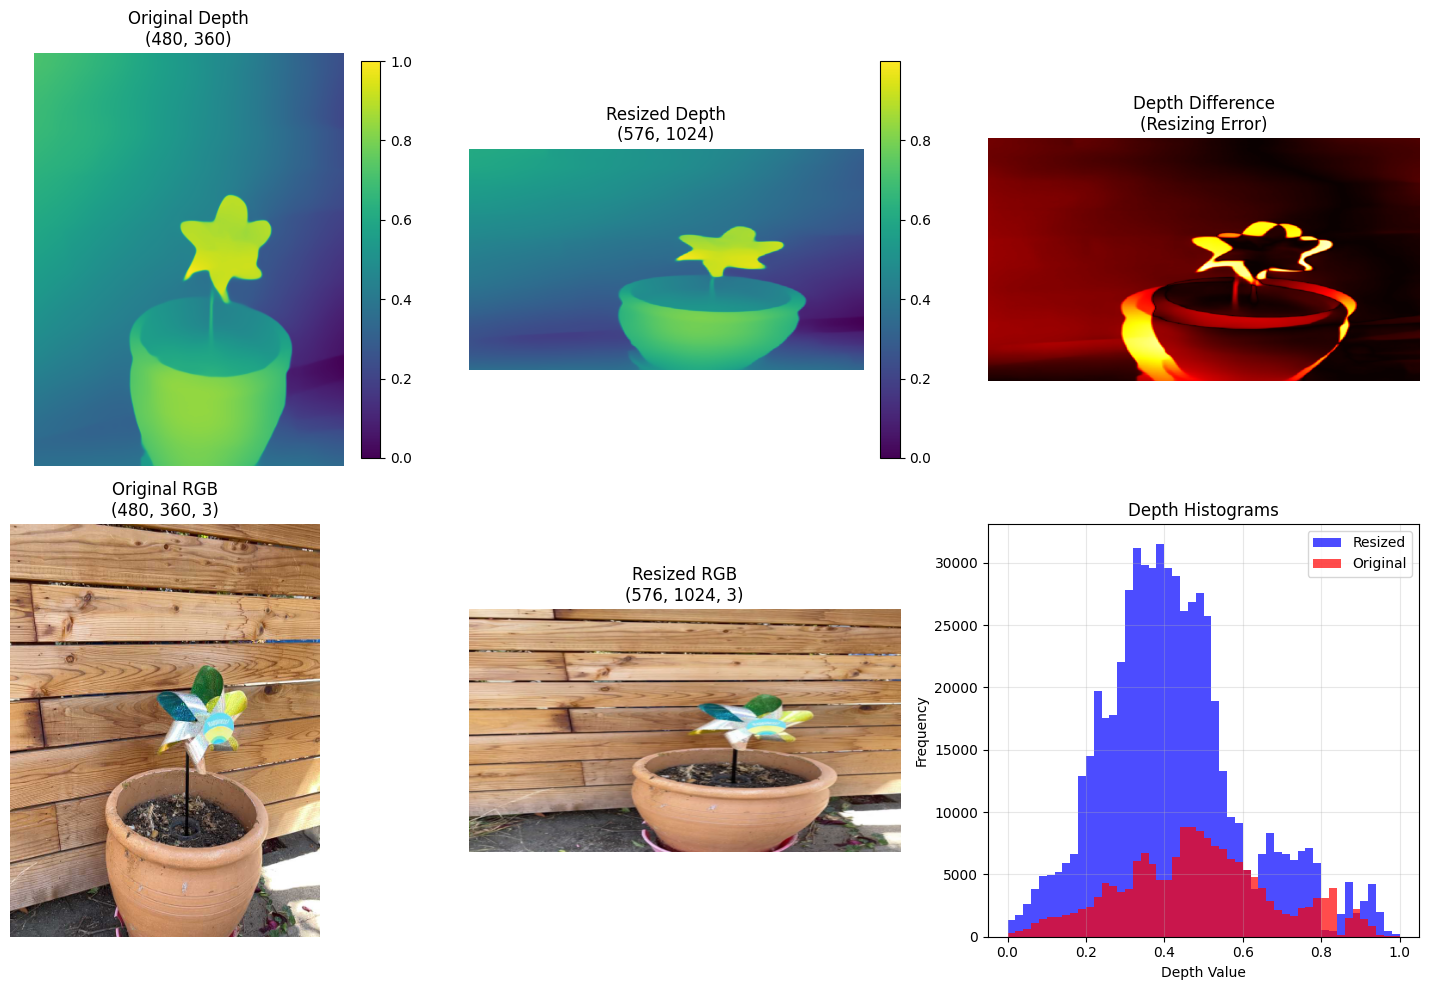

=== DEPTH STATISTICS ===
Original depth: (480, 360)
  Min: 0.0000
  Max: 1.0000
  Mean: 0.4838
  Std: 0.1953

Resized depth: (576, 1024)
  Min: 0.0000
  Max: 1.0000
  Mean: 0.4201
  Std: 0.1783

Resizing stats:
  Scale factor: 2.84x width, 1.20x height
  Max absolute difference: 0.6800
  Mean absolute difference: 0.0903


In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Plot depth image
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original depth (before resizing)
original_depth = train_sequence[0]['depth'].cpu().numpy()
axes[0, 0].imshow(original_depth, cmap='viridis')
axes[0, 0].set_title(f'Original Depth\n{original_depth.shape}')
axes[0, 0].axis('off')
axes[0, 0].set_xlabel(f'Range: [{original_depth.min():.3f}, {original_depth.max():.3f}]')
# add colorbar
cbar = plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0], fraction=0.046, pad=0.04)

# Resized depth (after processing)
resized_depth = prepared_data['depths'][0]  # [H, W]
axes[0, 1].imshow(resized_depth, cmap='viridis')
axes[0, 1].set_title(f'Resized Depth\n{resized_depth.shape}')
axes[0, 1].axis('off')
axes[0, 1].set_xlabel(f'Range: [{resized_depth.min():.3f}, {resized_depth.max():.3f}]')
# add colorbar
cbar = plt.colorbar(axes[0, 1].images[0], ax=axes[0, 1], fraction=0.046, pad=0.04)

# Depth difference (to see resizing artifacts)
# First resize original to match processed size for comparison
original_resized = cv2.resize(original_depth, (resized_depth.shape[1], resized_depth.shape[0]), interpolation=cv2.INTER_NEAREST)
depth_diff = np.abs(original_resized - resized_depth)
axes[0, 2].imshow(depth_diff, cmap='hot')
axes[0, 2].set_title(f'Depth Difference\n(Resizing Error)')
axes[0, 2].axis('off')
axes[0, 2].set_xlabel(f'Max diff: {depth_diff.max():.3f}')

# Original RGB
original_rgb = train_sequence[0]['original_image'].permute(1, 2, 0).cpu().numpy()[:,:,:3]
axes[1, 0].imshow(original_rgb)
axes[1, 0].set_title(f'Original RGB\n{original_rgb.shape}')
axes[1, 0].axis('off')

# Resized RGB
resized_rgb = prepared_data['frames'][0]  # [H, W, 3]
axes[1, 1].imshow(resized_rgb)
axes[1, 1].set_title(f'Resized RGB\n{resized_rgb.shape}')
axes[1, 1].axis('off')

# Depth histogram
axes[1, 2].hist(resized_depth.flatten(), bins=50, alpha=0.7, label='Resized', color='blue')
axes[1, 2].hist(original_depth.flatten(), bins=50, alpha=0.7, label='Original', color='red')
axes[1, 2].set_title('Depth Histograms')
axes[1, 2].set_xlabel('Depth Value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("=== DEPTH STATISTICS ===")
print(f"Original depth: {original_depth.shape}")
print(f"  Min: {original_depth.min():.4f}")
print(f"  Max: {original_depth.max():.4f}")
print(f"  Mean: {original_depth.mean():.4f}")
print(f"  Std: {original_depth.std():.4f}")

print(f"\nResized depth: {resized_depth.shape}")
print(f"  Min: {resized_depth.min():.4f}")
print(f"  Max: {resized_depth.max():.4f}")
print(f"  Mean: {resized_depth.mean():.4f}")
print(f"  Std: {resized_depth.std():.4f}")

print(f"\nResizing stats:")
print(f"  Scale factor: {resized_depth.shape[1]/original_depth.shape[1]:.2f}x width, {resized_depth.shape[0]/original_depth.shape[0]:.2f}x height")
print(f"  Max absolute difference: {depth_diff.max():.4f}")
print(f"  Mean absolute difference: {depth_diff.mean():.4f}")